# Advanced transfer learning: Fisher Information Averaging for ViT-b16


In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os

# Setting global variables to load pretrained models 
os.environ['TRANSFORMERS_CACHE'] = r"C:/Users/Leonardo/cache/hugging_face"

import warnings
warnings.filterwarnings('ignore')

Just a quick check on the GPU availability:

In [5]:
gpus = tf.config.experimental.list_physical_devices(device_type="GPU")
tf.config.experimental.set_visible_devices(devices=gpus[0], device_type="GPU")
tf.config.experimental.set_memory_growth(device=gpus[0], enable=True)

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [6]:
# To ensure reproducible results (as much as possible)
tf.keras.utils.set_random_seed(1234)

The idea behind my implementation is inspired by the numerical results in par.3.2 from [1]. The procedure is called WiSE-FT and is based on Fisher averaging for robust fine tuning. The ensambling algorithm based on Fisher information is applied to an initial model (ViT-b16) and 3 more different models obtained fine-tuning the original one on 3 different out of domain (OOD) datasets.

So for my work I'm going to import the following datasets leveraging ```tensorflow_datasets``` module (they are all different versions of ImageNet, the original training domain of ViT-b16):

+ ImageNet-A
+ ImageNet-R
+ ImageNet V2



In [7]:
# TODO: Insert all code here.
import tensorflow_datasets as tfds

imgNet_A_train = tfds.load('imagenet_a', as_supervised=True, split='test[0:80%]')
imgNet_A_test = tfds.load('imagenet_a', as_supervised=True, split='test[80%:]')

imgNet_R_train = tfds.load('imagenet_r', as_supervised=True, split='test[0:80%]')
imgNet_R_test = tfds.load('imagenet_r', as_supervised=True, split='test[80%:]')

imgNet_V2_train = tfds.load('imagenet_v2', as_supervised=True, split='test[0:80%]')
imgNet_V2_test = tfds.load('imagenet_v2', as_supervised=True, split='test[80%:]')

We are defining a mapping between the integer labels and the textual label (ref. https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a#file-imagenet1000_clsidx_to_labels-txt).

In [8]:
from urllib.request import urlretrieve
import zipfile

urlretrieve("https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a/archive/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5.zip","labels.zip")

with zipfile.ZipFile('labels.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall(r'labels')

labels_map = {}

with open("labels/942d3a0ac09ec9e5eb3a-238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt", 'r') as file:
        for line in file:
          line = line.lstrip("{")
          line = line.rstrip("}")
          key, value = line.strip().split(":", 1)
          labels_map[int(key)] = value[2:len(value)-2]

As stated in the documentation of the datasets, when loaded with the attribute ```as_supervised``` the imgNet alias always have two features:
+ The ```image``` as a 3 channel tensor of variable width and height;
+ The ```label``` as a TensorFlow scalar.

In [7]:
imgNet_A_train.element_spec

(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [8]:
imgNet_R_train.element_spec

(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [9]:
imgNet_V2_train.element_spec

(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Let's have a look to some examples from ImageNet-A:


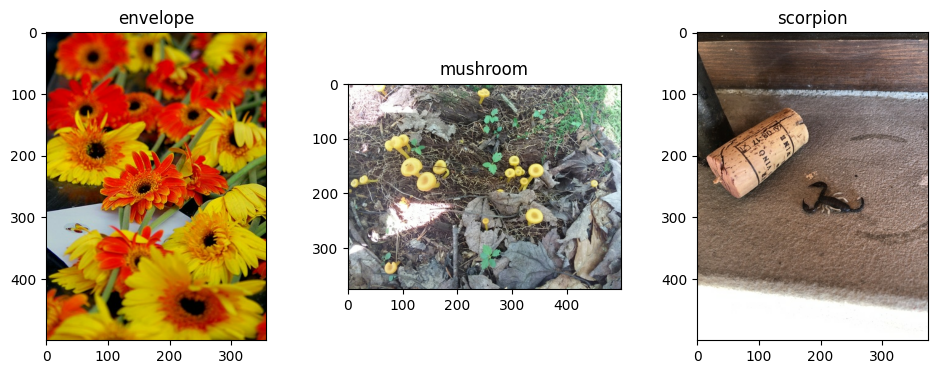

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
it = iter(imgNet_A_train)
for i in range(3):
  elem = next(it)
  axs[i].imshow(elem[0])
  axs[i].set_title(f"{labels_map[elem[1].numpy()]}")

We are going to need a standard preprocessing with normalization and resizing to (224,224). We also need to transpose the image to match the HuggingFace standards: infact transformers requires the tensor to be in channels-first format.

In [5]:
def preprocessing(image, label):
    resized_image = tf.image.resize(image, (224, 224))/255.0
    return tf.transpose(resized_image, (2, 0, 1)), label

In [6]:
imgNet_A_train = imgNet_A_train.map(preprocessing)
imgNet_A_test = imgNet_A_test.map(preprocessing)

imgNet_R_train = imgNet_R_train.map(preprocessing)
imgNet_R_test = imgNet_R_test.map(preprocessing)

imgNet_V2_train = imgNet_V2_train.map(preprocessing)
imgNet_V2_test = imgNet_V2_test.map(preprocessing)

### Implementing a pipeline for Fisher Information Model Averaging


The whole procedure can be sketched as follows:

a) Load the pretrained ```ViT-b16``` model from Hugging Face Hub;

b) Fine-tune the model on the three OOD datasets, retrieving three new model;

c) Implement a procedure to compute an estimate of the Fisher Information matrix for the parameters of each model. As stated in the reference paper the Fisher Information matrix for a neural network parametrized by $\theta$ to learn a probability distribution $p_{\theta}(y|x)$ to predict $y$ from input data $x$ is a positive semidefinite matrix given by the following equation:
\begin{equation}
F_{\theta} = \mathbb{E}_x[\mathbb{E}_{p_{\theta}(y|x)} \nabla_{\theta} \log p_{\theta}(y|x) \nabla \log p_{\theta}(y|x)^T]
\end{equation}

We are going to use the diagonal of the following plug-in estimate:

\begin{equation}
\hat{F}_{\theta} = \frac{1}{N} \sum_{i=1}^N \mathbb{E}_{y \sim p_{\theta}(y|x_i)} (\nabla_{\theta} \log p_{\theta}(y|x_i))^2
\end{equation}

where $x_1, ..., x_N$ are drawn IID from the training set.

d) Implement a procedure to merge the models through Fisher averaging: the point is to find a set of parameters that maximize the probability the posterior distribution of all the parameters. So we want to solve

\begin{equation}
\theta^* = argmax \ \sum_{i=1}^M \lambda_i \log p(\theta|\theta_i, F_i)
\end{equation}

whose solution is

\begin{equation}
\theta^{(j)} = \frac{\sum_{i=1}^M \lambda_i F_i^{(j)}\theta_i^{(j)}}{\sum_{i=1}^M \lambda_i F_i^{(j)}}
\end{equation}

This is basically a weighted averaging of the parameters of the model.

e) Evaluate the performance of the new model.


#### a) Loading the model and creating 3 istances of it

We are going to leverage ```transformers``` library to import the ViT model from HuggingFace.

In [7]:
from transformers import TFViTForImageClassification

In [7]:
model_name = "google/vit-base-patch16-224"
model_A = TFViTForImageClassification.from_pretrained(model_name, num_labels=1000)
model_R = TFViTForImageClassification.from_pretrained(model_name, num_labels=1000)
model_V2 = TFViTForImageClassification.from_pretrained(model_name, num_labels=1000)

All PyTorch model weights were used when initializing TFViTForImageClassification.

All the weights of TFViTForImageClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTForImageClassification for predictions without further training.
All PyTorch model weights were used when initializing TFViTForImageClassification.

All the weights of TFViTForImageClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTForImageClassification for predictions without further training.
All PyTorch model weights were used when initializing TFViTForImageClassification.

All the weights of TFViTForImageClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTForImageClassification for predictions 

Now let's define some useful variables batch the datasets, compile the models and perform the actual fine-tuning.

In [8]:
num_train_epochs = 5
train_batch_size = 2
eval_batch_size = 2
learning_rate = 3e-5

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [9]:
train_A_dataset = imgNet_A_train.batch(train_batch_size).shuffle(buffer_size=100).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_A_dataset = imgNet_A_test.batch(eval_batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

train_R_dataset = imgNet_R_train.batch(train_batch_size).shuffle(buffer_size=100).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_R_dataset = imgNet_R_test.batch(eval_batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

train_V2_dataset = imgNet_V2_train.batch(train_batch_size).shuffle(buffer_size=100).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_V2_dataset = imgNet_V2_test.batch(eval_batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [12]:
model_A.compile(optimizer=optimizer,
              loss=loss,
              metrics=['accuracy'])

model_R.compile(optimizer=optimizer,
              loss=loss,
              metrics=['accuracy'])

model_V2.compile(optimizer=optimizer,
              loss=loss,
              metrics=['accuracy'])

#### b) Fine-tuning the three models on three different OOD datasets

In [18]:
model_A.fit(train_A_dataset, epochs=num_train_epochs)

Epoch 1/3


3000/3000 [==============================] - 430s 136ms/step - loss: 2.8212 - accuracy: 0.3833
Epoch 2/3
3000/3000 [==============================] - 408s 136ms/step - loss: 0.7264 - accuracy: 0.8187
Epoch 3/3
3000/3000 [==============================] - 405s 135ms/step - loss: 0.1813 - accuracy: 0.9640


Save the model leveraging ```transformer``` methods:

In [19]:
model_A.save_pretrained('vit_b16_Aft', saved_model=True)

INFO:tensorflow:Assets written to: vit_b16_Aft\saved_model\1\assets


INFO:tensorflow:Assets written to: vit_b16_Aft\saved_model\1\assets


In [14]:
model_R.fit(train_R_dataset, epochs=num_train_epochs)

Epoch 1/3


12000/12000 [==============================] - 1676s 138ms/step - loss: 1.3107 - accuracy: 0.7098
Epoch 2/3
12000/12000 [==============================] - 1669s 139ms/step - loss: 0.3420 - accuracy: 0.9155
Epoch 3/3
12000/12000 [==============================] - 1663s 139ms/step - loss: 0.0844 - accuracy: 0.9808


In [15]:
model_R.save_pretrained('vit_b16_Rft', saved_model=True)

INFO:tensorflow:Assets written to: vit_b16_Rft\saved_model\1\assets


INFO:tensorflow:Assets written to: vit_b16_Rft\saved_model\1\assets


In [14]:
model_V2.fit(train_R_dataset, epochs=num_train_epochs)

Epoch 1/3
12000/12000 [==============================] - 1677s 138ms/step - loss: 1.2466 - accuracy: 0.7247
Epoch 2/3
12000/12000 [==============================] - 1633s 136ms/step - loss: 0.3826 - accuracy: 0.9129
Epoch 3/3
12000/12000 [==============================] - 1620s 135ms/step - loss: 0.3826 - accuracy: 0.9129


In [15]:
model_V2.save_pretrained('vit_b16_V2ft', saved_model=True)

INFO:tensorflow:Assets written to: vit_b16_V2ft\saved_model\1\assets


INFO:tensorflow:Assets written to: vit_b16_V2ft\saved_model\1\assets


We can load back our models using ```from_pretrained``` method but passing as path the one where we saved the fine-tuned model (to make this and further cells run you should download the .zip file following this [link](https://drive.google.com/file/d/1LMSNktMPbfyIxDIfrEaxJTMwAuWvAoUH/view?usp=sharing) where I put all the models I trained for this work )

In [10]:
model_A = TFViTForImageClassification.from_pretrained('vit_b16_Aft', num_labels=1000)

# Recompile it
model_A.compile(optimizer=optimizer,
              loss=loss,
              metrics=['accuracy'])

model_R = TFViTForImageClassification.from_pretrained('vit_b16_Rft', num_labels=1000)

# Recompile it
model_R.compile(optimizer=optimizer,
              loss=loss,
              metrics=['accuracy'])

model_V2 = TFViTForImageClassification.from_pretrained('vit_b16_V2ft', num_labels=1000)

# Recompile it
model_V2.compile(optimizer=optimizer,
              loss=loss,
              metrics=['accuracy'])

All model checkpoint layers were used when initializing TFViTForImageClassification.

All the layers of TFViTForImageClassification were initialized from the model checkpoint at vit_b16_Aft.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTForImageClassification for predictions without further training.
All model checkpoint layers were used when initializing TFViTForImageClassification.

All the layers of TFViTForImageClassification were initialized from the model checkpoint at vit_b16_Rft.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTForImageClassification for predictions without further training.
All model checkpoint layers were used when initializing TFViTForImageClassification.

All the layers of TFViTForImageClassification were initialized from the model checkpoint at vit_b16_V2ft.
If your task is similar to the task the model of the checkpoint was trained on, you ca

#### c) Implement a procedure for the estimation of the diagonal of the Fisher information matrix of the model 

We can unpack this equation: 

\begin{equation}
\hat{F}_{\theta} = \frac{1}{N} \sum_{i=1}^N \mathbb{E}_{y \sim p_{\theta}(y|x_i)} [\nabla_{\theta} \log p_{\theta}(y|x_i)]^2
\end{equation}

to clearly understand the nature of that inner expectation: being an expected value over a discrete distribution, it can be recasted as a sum; more over it is a finite sum in this case. So being $L$ the number of labels in our classification task, we have: 

\begin{equation}
\hat{F}_{\theta} = \frac{1}{N} \sum_{i=1}^N \{\sum_{l=1}^L (\nabla_{\theta} \log p_{\theta}(y_l|x_i))^2 p_{\theta}(y_l|x_i)\}
\end{equation}


We are going to define proper functions wrapped in ```tf.function``` to do so. 

In [11]:
B = 1               # Since we want to iterate element by element now the batch size must be 1
num_labels = 1000

train_A_dataset = imgNet_A_train.batch(B).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_A_dataset = imgNet_A_test.batch(B).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

train_R_dataset = imgNet_R_train.batch(B).shuffle(buffer_size=100).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_R_dataset = imgNet_R_test.batch(B).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

train_V2_dataset = imgNet_V2_train.batch(B).shuffle(buffer_size=100).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_V2_dataset = imgNet_V2_test.batch(B).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

The routine is implemented requiring some external initialization:
+ ```model``` is clearly required as the model of interest for the procedure;
+ ```aggregator``` is a list of tensors all initalized to zero having the same shape of respective tensors in ```parameters``` list: the function ```_zeros_initializer``` deals with this input;
+ ```variables``` is the list of mergeable parameters that can be easily accesed through the attribute ```trainable_variables``` on a certain model;
+ ```samples``` is a subset of training data retrieved through the tensorflow method ```take```
+ ```N``` is the number of samples from the training set considered to approximate the Fisher's information matrix. 

In [12]:
def _zeros_initizializer(variables, initializer):
    outs = []
    for w in variables:
        outs.append(tf.Variable(initializer(shape=w.shape, dtype=tf.float32)))
    return outs

@tf.function
def Fisher_proxy(model, aggregator, variables, samples, N):
    fishers = aggregator
    for batch, _ in samples:
        with tf.GradientTape() as tape:
            tape.watch(variables)
            
            logits = model(batch, training=False).logits

            # We need to compute the gradient of the log-prob
            log_probs = tf.nn.log_softmax(logits)
            grads = tape.gradient(log_probs, variables)

            # We need to probabilities to compute the expectation as a finite sum
            probs = tf.nn.softmax(logits)[0]
            
            # We multiply the squared gradient of the log-probs by the probs
            sq_grad = [[probs[i]*tf.square(g) for i, g in enumerate(grads)]]

            #...to then collapse on the labels dimension 
            sample_fisher = [tf.reduce_sum(g, axis=0) for g in zip(*sq_grad)]
        
        # Then we track the process using the aggregator...
        for f, bf in zip(fishers, sample_fisher):
            f.assign_add(bf)
            
    #...to finally get the average
    for fisher in fishers:
        fisher.assign(fisher/N)

    return fishers

We need some explicit for-looping since the mergeable variables of the model are given as a list of tensors: when we call ```tape.gradient()``` on a list of variables TensorFlow yields a list of gradients, so the framework can handle lists of variables but then every further operation on them must be done through explicit loops.

The only meaningful vectorization we could do is through ```tf.vectorized_map``` defining a basic operation over a single batch and then calling this TensorFlow built-in as a mapping of this basic operation on the whole dataset of interest, but in this case the main loop over the dataset looks more reasonable since to call a ```tf.vectorized_map``` we need:

+ A callable ```fn``` to be performed element-wise
+ A tensor ```elems``` that should collect on the first axis all the elements to be mapped: building this tensor would require a lot of effort, making the vectorization unesuful in the end.

In [13]:
par_A = model_A.trainable_variables.copy()
agg_A = _zeros_initizializer(par_A, tf.zeros_initializer())
samples_A = train_A_dataset.take(1000)
f_A = Fisher_proxy(model_A, agg_A, par_A, samples_A, 1000)

In [14]:
par_R = model_R.trainable_variables.copy()
agg_R = _zeros_initizializer(par_R, tf.zeros_initializer())
samples_R = train_R_dataset.take(1000)
f_R = Fisher_proxy(model_R, agg_R, par_R, samples_R, 1000)

In [15]:
par_V2 = model_V2.trainable_variables.copy()
agg_V2 = _zeros_initizializer(par_V2, tf.zeros_initializer())
samples_V2 = train_V2_dataset.take(1000)
f_V2 = Fisher_proxy(model_V2, agg_V2, par_V2, samples_V2, 1000)

#### d) Define a procedure to merge the models 

We can just leverage the estimated diagonal of Fisher information matrix of each model and plug them in this formula: 

\begin{equation}
\theta^{(j)} = \frac{\sum_{i=1}^M \lambda_i \hat{F}_i^{(j)}\theta_i^{(j)}}{\sum_{i=1}^M \lambda_i \hat{F}_i^{(j)}}
\end{equation}


In [16]:
thetas = [par_A, par_R, par_V2]
F = [f_A, f_R, f_V2]

We also need an istance of the model where we are going to set the parameters equal to the ones retrieved through this weighted averaging. 

In [17]:
model_name = "google/vit-base-patch16-224"

new_model = TFViTForImageClassification.from_pretrained(model_name, num_labels=1000)

All PyTorch model weights were used when initializing TFViTForImageClassification.

All the weights of TFViTForImageClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTForImageClassification for predictions without further training.


So we are now going to implement two functions: 
- ```Fisher_averaging``` is going to implement the equation in eq.4(), par. 2.4 from the reference paper;
- ```Isotropic_averaging``` instead is going to implement a vanilla weighted average of the parameters. 

In [18]:
def Fisher_averaging(vessel, params, fs, lambda_):
    M = len(params)
    new_params = _zeros_initizializer(vessel.trainable_variables, tf.zeros_initializer())
    for j in range(len(params[0])):
        norm = 0
        for i in range(M):
            new_params[j].assign_add(lambda_[i]*fs[i][j]*params[i][j])
            norm += lambda_[i]*fs[i][j]
        new_params[j].assign(new_params[j]/norm)

    return new_params

def Isotropic_averaging(vessel, params, lambda_):
    M = len(params)
    new_params = _zeros_initizializer(vessel.trainable_variables, tf.zeros_initializer())
    for j in range(len(params[0])):
        for i in range(M):
            new_params[j].assign_add(lambda_[i]*params[i][j])
    
    return new_params

#### e) Evaluate the implementation

We are going to consider the following heuristic to define a suitable $\lambda$ and do some analysis on the results. We are going to evaluate the three fine tuned models on the respective validation sets, and we are going to gather a vector with three accuracy scores. Then we are simply considering it normalized to have sum equal to one as our $\lambda$ for a first example.

In [19]:
_, acc_A = model_A.evaluate(test_A_dataset)
_, acc_R = model_R.evaluate(test_R_dataset)
_, acc_V2 = model_V2.evaluate(test_V2_dataset)

accs_ = tf.constant([acc_A, acc_R, acc_V2])
accs_ /= tf.reduce_sum(accs_)
accs_ = accs_.numpy().tolist()

2000/2000 [==============================] - 83s 39ms/step - loss: 3.4507 - accuracy: 0.4015


In [20]:
new_params_F = Fisher_averaging(new_model, thetas, F, accs_)
new_params_iso = Isotropic_averaging(new_model, thetas, accs_)

Finally we can do some evaluation to state the results of this framework.

#### _Compare the Fisher merging and the Isotropic merging with respect to the validation accuracy on the three OOD datasets_

Firstly we instatiante the model two times: the first is going to inherit the Fisher averaged parameters, the second the isotropic averaged parameters. We compile them and evaluate their accuracy on three validation OOD we considered at the beginning. 

In [21]:
new_model_iso = TFViTForImageClassification.from_pretrained(model_name, num_labels=1000)
new_model_F = TFViTForImageClassification.from_pretrained(model_name, num_labels=1000)

new_model_F.set_weights(new_params_F)
new_model_iso.set_weights(new_params_iso)

All PyTorch model weights were used when initializing TFViTForImageClassification.

All the weights of TFViTForImageClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTForImageClassification for predictions without further training.
All PyTorch model weights were used when initializing TFViTForImageClassification.

All the weights of TFViTForImageClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTForImageClassification for predictions without further training.


In [25]:
new_model_F.compile(optimizer=optimizer,
              loss=loss,
              metrics=['accuracy'])

new_model_iso.compile(optimizer=optimizer,
              loss=loss,
              metrics=['accuracy'])

In [26]:
val_sets = [test_A_dataset, test_R_dataset, test_V2_dataset]
oods = ['ImageNet-A', 'ImageNet-R', 'ImageNet V2']
accs = {ood: {'Fisher':None, 'Isotropic':None} for ood in oods}

for i in range(3): 
    _, acc_F = new_model_F.evaluate(val_sets[i])
    _, acc_iso = new_model_iso.evaluate(val_sets[i])
    accs[oods[i]]['Fisher'] = acc_F
    accs[oods[i]]['Isotropic'] = acc_iso

2000/2000 [==============================] - 87s 44ms/step - loss: 2.4672 - accuracy: 0.5265


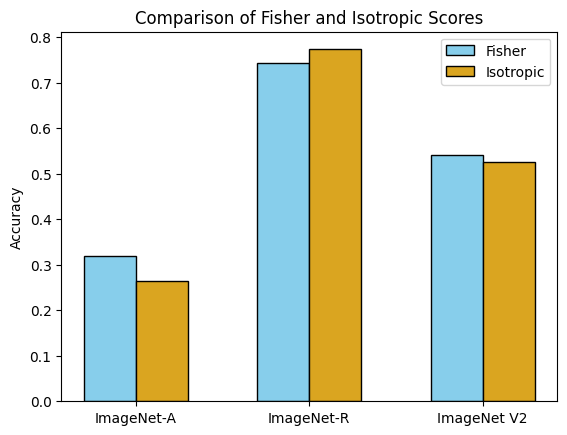

In [27]:
import numpy as np

labels = list(accs.keys())
fisher_values = [inner_dict['Fisher'] for inner_dict in accs.values()]
isotropic_values = [inner_dict['Isotropic'] for inner_dict in accs.values()]

bar_width = 0.3
index = np.arange(len(labels))

fig, ax = plt.subplots()
bar1 = ax.bar(index, fisher_values, bar_width, label='Fisher', edgecolor='black', color='skyblue')
bar2 = ax.bar(index + bar_width, isotropic_values, bar_width, label='Isotropic', edgecolor='black', color='goldenrod')

ax.set_ylabel('Accuracy')
ax.set_title('Comparison of Fisher and Isotropic Scores')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

This plot may look discouraging, since the Fisher-based model is outperformed by the isotropic on ImageNet-R, but we should remember that in the Fisher merging there is a free parameter $\lambda$ that can be optimized through a search procedure. This was just an example based on an idea for $\lambda$ based on the respective validation accuracy of the three models: it is still interesting to see that the Fisher model outperforms the isotropic one on the OOD where the validation score among the three fine-tuned model was the worst. 

In [22]:
new_model_F.save_pretrained('Fisher_merged_ViTs', saved_model=True)

INFO:tensorflow:Assets written to: Fisher_merged_ViTs\saved_model\1\assets


INFO:tensorflow:Assets written to: Fisher_merged_ViTs\saved_model\1\assets


### Interpreting the results through LIME framework

In [10]:
# Let's call back the model we get from our previous work 
from transformers import TFViTForImageClassification

optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model = TFViTForImageClassification.from_pretrained('Fisher_merged_ViTs', num_labels=1000)
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=['accuracy'])

All model checkpoint layers were used when initializing TFViTForImageClassification.

All the layers of TFViTForImageClassification were initialized from the model checkpoint at Fisher_merged_ViTs.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTForImageClassification for predictions without further training.


We are given a certain model $f$ whose prediction we want to explain. We consider $x' \in \mathbb{R}^{d'}$ to be the explainable version of an istance $x$ of the task-set of $f$: in the case of an image-classification it can be the image segmentation. In particular we can model the intepretable instance as a $\{0,1\}^{d'}$ vector indicating the presence or the absence of the interpretable feature.

We then consider $g \in \mathcal{G}$ to be a model within the class of linear models, that are naturally interpretable: we can impute importante to the features through the weights of the model: the interpretable elements are the features of this model.

What the procedure do is to sample non-zero elements from the interpretable instance obtaining perturbed versions of the original one: then the model $f$ is used to compute a prediction that acts as a label for the perturbed element, and repeating this step we get a dataset perfect for a supervised learning problem. 

The idea behind LIME is to solve the following problem:

\begin{equation}
    \mathrm{argmin}_{g \in \mathcal{G}}\{K_D(z,z')(f(z)-g(z'))^2 + \Omega(g)\}
\end{equation}

where $K_D(x,z)$ is a kernel with a notion of distance (a common choice is the gaussian kernel $K_D(z,z')=\mathrm{exp}\{-\frac{-D(z,z')^2}{\sigma^2}\}$) and $\Omega$ is a notion of complexity of the model, contrasting with interpretability (for example a term penalizing sparsity, i.e. a LASSO approach): the problem is a penalized weighted linear regression. 

In the case of image-classification task the interpretable feature is usually a super-pixel: in our case a reasonable choice could be considering the 16x16 patches the vision transformer is based on. So firstly we can write a function to divide an image in patches and a function to rebuild back an image, eventually in a "disturbed" instance. 

We'll consider one image coming from ImgNet-R, since it was the OOD where our final model performed the best. 

In [11]:
imgNet_R_test = tfds.load('imagenet_r', as_supervised=True, split='test[80%:]')

In [12]:
it = iter(imgNet_R_test)
img, true = next(it)

image = tf.reshape(tf.image.resize(img, (224, 224))/255.0, [1, 224, 224, 3])
predicted_class = tf.math.argmax(tf.nn.softmax(model(tf.transpose(image, [0,3,1,2]))[0])[0])

Text(0.5, 1.0, 'Predicted class: 245 - French bulldog \n True class: 245 - French bulldog')

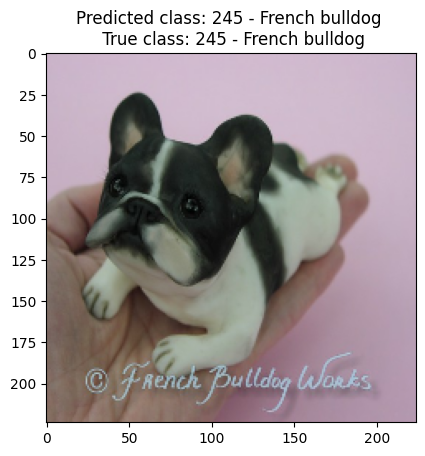

In [13]:
plt.imshow(image[0])
plt.title(f"Predicted class: {predicted_class} - {labels_map[predicted_class.numpy()]} \n True class: {true} - {labels_map[true.numpy()]}")

The following functions leverages TensorFlow built-ins to extract 16x16 patches from an image.

In [14]:
def patcher(image):
    ksizes = [1, 16, 16, 1]
    strides = [1, 16, 16, 1]                    # We want the patches to be non overlapping
    rates = [1, 1, 1, 1]
    patches = tf.image.extract_patches(images=image, sizes=ksizes, strides=strides, rates=rates, padding='VALID')
    return tf.reshape(patches, [-1, 16, 16, 3])

In [15]:
patches = patcher(image)
patches.shape

TensorShape([196, 16, 16, 3])

Now we want to define a 0-1 vectors matching the number of patches to create a perturbed instance of the image. The stateless version of the binomial random generator requires a seed so when we are going to define the perturbed dataset we'll need different seeds to get different output tensors. We define the function to also output a mask matching the dimension of our patches. 

In [16]:
def random_mask(seed,num_trials=1,p=0.5,shape=196):
    random_binomial_samples = tf.random.stateless_binomial(tf.constant([shape]), 
                                                        seed=seed, 
                                                        counts=num_trials, 
                                                        probs=p,
                                                        output_dtype=tf.dtypes.float32)
    
    return random_binomial_samples, tf.tile(tf.reshape(random_binomial_samples, (196, 1, 1, 1)), [1, 16, 16, 3])

In [17]:
_, image_mask = random_mask((1,3))

Let's see what we got: 

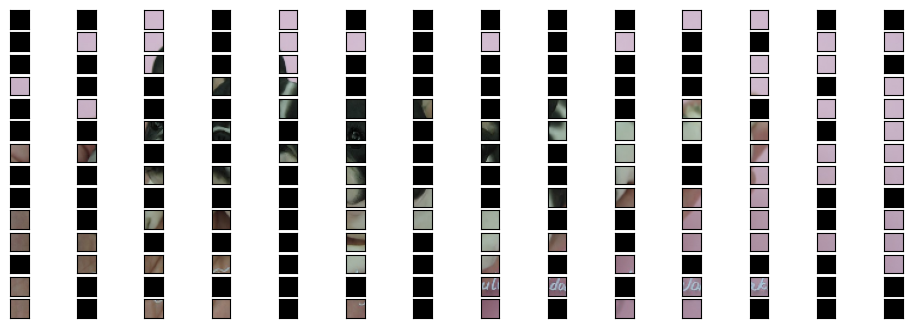

In [18]:
masked_patches = image_mask*patches

fig, axs = plt.subplots(14, 14, figsize=(12, 4))

k = 0 
for i in range(14):
  for j in range(14):
    elem = next(it)
    axs[i][j].imshow(masked_patches[k])
    axs[i][j].set_xticks([])
    axs[i][j].set_yticks([])

    k += 1

This function builds back the original image from its patches. 

In [19]:
def depatcher(patches, shape=(224,224,3), patch_size=(16, 16)):
    num_patches_height = shape[0] // patch_size[0]
    num_patches_width = shape[1] // patch_size[1]

    patches = tf.reshape(patches, [num_patches_height, num_patches_width, patch_size[0], patch_size[1], -1])

    patches = tf.transpose(patches, (0, 2, 1, 3, 4))
    recomposed_image = tf.reshape(patches, [shape[0], shape[1], -1])

    return recomposed_image

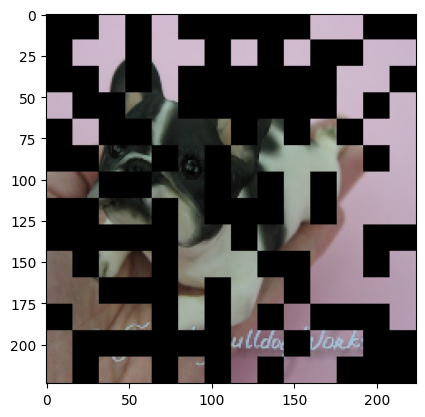

In [20]:
plt.imshow(depatcher(masked_patches))

Now we want to repack all of this in a single pipeline taking into account that for ViT the standard for image dimensions is channel-first and that we should add a batch dimension and providing also all the other elements we need for the LIME implementation. In particular the function ```disturbed``` is going to take as input an ```image``` and a ```seed``` for the random mask and its output is a dictionary containing:

+ The random mask: it is going to be the feature vector in our linear model;
+ The model prediction as the probability associated to the correct class: it is going to be the ground truth label in the supervised dataset we are going to provide to our linear model. 
+ The weight computed through a gaussian kernel over the L2 distance between the image and its disturbed reconstruction (we considered a high variance for the kernel since every distance between an image and one variation with masked patch would be high even with little masking );

In [23]:
def disturbed(image, seed, model_ = model, correct_class = 245, var = float(10000)):
    patches = patcher(image)
    mask, image_mask = random_mask(seed)
    patches = image_mask*patches

    # Distance between the original image and the one reconstructed from the masked patches
    D = tf.math.reduce_euclidean_norm(image - depatcher(patches), axis=None, keepdims=False, name=None)

    # The disturbed images made digestible from the model
    disturbed_image = tf.expand_dims(tf.transpose(depatcher(patches), (2, 0, 1)), axis=0)

    # The model prediction as the probability associated to the correct class (??\ I'm not completely sure what f(z) refers in the paper but it makes sense to me to take the prob associated to the correct class
                                                                             # I also considered simply the highest probability the model outputs when digesting the disturbed image but did not make too much sense to me)
    
    label = tf.nn.softmax(model_(disturbed_image)[0])[0][correct_class]

    return {'Mask':mask,
            'Label':label,
            'Weight':tf.math.exp(-D**2/var)}

In [24]:
disturbed(image,(1,1))

{'Mask': <tf.Tensor: shape=(196,), dtype=float32, numpy=
 array([1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0.,
        1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0.,
        1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0.,
        0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0.,
        1., 1., 1., 1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 0., 0.,
        1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1.,
        0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0.,
        0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 1.,
        1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
        1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1.,
        1., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 1., 0., 0., 1., 1., 1., 1.], dtype=float32)>,
 'Label': <tf.Tensor: shape=(), dtype=float32

Now we need a certain number of random samples $N$ from the neighborhood of the original image, i.e. a certain number of random masks to get our supervised training set for our linear model. 

In [25]:
dataset = []
N = 200
for i in range(N):
    dataset.append(disturbed(image,(i,i+1)))

In [30]:
dataset[0]

{'Mask': <tf.Tensor: shape=(196,), dtype=float32, numpy=
 array([0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0.,
        1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1.,
        0., 0., 1., 0., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1.,
        1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0.,
        1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0.,
        1., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0.,
        0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 1.,
        0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0.,
        1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1.,
        1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0.,
        0., 1., 1., 0., 0., 0., 0., 1., 0.], dtype=float32)>,
 'Label': <tf.Tensor: shape=(), dtype=float32

In [26]:
X = tf.constant(np.array([d['Mask'].numpy() for d in dataset]))
y = tf.constant(np.array([d['Label'].numpy() for d in dataset]))
weights = tf.constant(np.array([d['Weight'].numpy() for d in dataset]))

Time for a linear regression over our brand new dataset: we have to define a custom loss measure, then a single layer neural network will be enough for our task. 

In [27]:
def weighted_mean_squared_error(y_true, y_pred, w=weights):
    return tf.reduce_mean(tf.square(y_true-y_pred)*w)

linear_regression = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1, 
                          input_shape=(196,),
                          kernel_regularizer=tf.keras.regularizers.L1(l1=0.4))                 # The paper stated the algorithm as a LASSO regression
])

linear_regression.compile(optimizer='sgd', loss=weighted_mean_squared_error)
linear_regression.fit(X, y, epochs=40, batch_size=32) 

Epoch 1/40
7/7 [==============================] - 0s 5ms/step - loss: 6.0990
Epoch 2/40
7/7 [==============================] - 0s 8ms/step - loss: 4.1339
Epoch 3/40
7/7 [==============================] - 0s 5ms/step - loss: 2.6186
Epoch 4/40
7/7 [==============================] - 0s 4ms/step - loss: 1.4886
Epoch 5/40
7/7 [==============================] - 0s 4ms/step - loss: 0.7064
Epoch 6/40
7/7 [==============================] - 0s 3ms/step - loss: 0.3065
Epoch 7/40
7/7 [==============================] - 0s 4ms/step - loss: 0.1870
Epoch 8/40
7/7 [==============================] - 0s 3ms/step - loss: 0.1798
Epoch 9/40
7/7 [==============================] - 0s 4ms/step - loss: 0.1800
Epoch 10/40
7/7 [==============================] - 0s 4ms/step - loss: 0.1789
Epoch 11/40
7/7 [==============================] - 0s 3ms/step - loss: 0.1785
Epoch 12/40
7/7 [==============================] - 0s 5ms/step - loss: 0.1779
Epoch 13/40
7/7 [==============================] - 0s 3ms/step - loss: 0.

Now we can have a look to the patch importance using the model weights:

In [28]:
w_g = linear_regression.get_weights()[0]

idxs = tf.constant(tf.argsort(w_g[:,0])[-50:],dtype=tf.int32)                                   # Retrieve the 50 most important patches

# scatter_nd is the methods to compactly update a tensor of a given shape on certain indices
mask = tf.scatter_nd(indices=tf.expand_dims(idxs, axis=1),                                      # In this way we are basically transposing the idxs tensor                                  
                     updates=tf.ones_like(idxs, dtype=tf.float32),
                     shape=tf.constant([196]))

mask = tf.tile(tf.reshape(mask, (196, 1, 1, 1)), [1, 16, 16, 3])

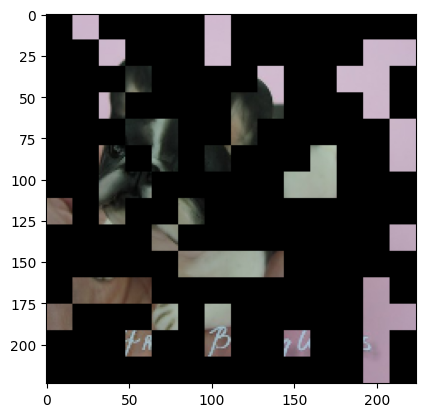

In [29]:
masked_patches = patches*mask
plt.imshow(depatcher(masked_patches))

Apparently the model seems reasonable in predicting, but not too much: we should remember that we are working with the result of the merging of three models, so it is appreciable how it attaches importance to some patches clearly referable to the correct classification. 

# Bibliography

 [1] "Merging Models with Fisher-Weighted Averaging", Matena M., Raffel C., 2022 
 
 [2] "Why Should I Trust You?": Explaining the Predictions of Any Classifier, Ribeiro M.T., Singh S., Guestrin C., 2016
